# Exam 

### Imports

In [25]:
import quantkit as q
from quantkit import Compute_H_FSS_sparse, generate_initial_state, generate_random_state, Compute_H_schwinger_sparse, compute_expectations, plot_expectations, compare_models, psi_t
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')

## Simulation


### Global Parameters

In [26]:
# -----------------------------
# Rydberg Chain
# -----------------------------

Omega = 2. 
delta = 0.
L     = 11

# -----------------------------
# Schwinger Model
# -----------------------------

w = 4./L
m = 0. * w
J = 1.5 * w
alpha = -0.5
L_s = 11

# -----------------------------
# Initial states
# -----------------------------

# Rydberg
P = q.blockade_projection_matrix(L)

initial_state_r = generate_initial_state(L, 'q-q-bar-pair')
#perturbation = generate_random_state(2**L) * 0.0
#initial_state_r += perturbation
#initial_state_r /= np.linalg.norm(initial_state_r)
initial_state_r = P @ initial_state_r

# Schwinger
psi0_s = generate_initial_state(L_s, 'q-q-bar-pair')

### Hamiltonians and Diagonalization

In [27]:
# Rydberg
L_eff = P.shape[0]
H_FSS = P @ Compute_H_FSS_sparse(Omega, delta, L) @ P.T
H_FSS = H_FSS.todense()
e_vals_r, e_vecs_r = np.linalg.eigh(H_FSS)
C_r = np.ravel(e_vecs_r.conj().T @ initial_state_r)

# Schwinger
H_sch = Compute_H_schwinger_sparse(w, m, J, alpha, L_s).todense()
e_vals_s, e_vecs_s = np.linalg.eigh(H_sch)
C_s = np.ravel(e_vecs_s.conj().T @ psi0_s)

### Time Evolution

In [28]:
t_vals = np.linspace(0, 20, 200)

# Function to produce |psi(t)> arrays
psi_t_r_list = [np.ravel(psi_t(t, e_vals_r, e_vecs_r, C_r, normalize=True)) for t in t_vals]
psi_t_s_list = [np.ravel(psi_t(t, e_vals_s, e_vecs_s, C_s, normalize=False)) for t in t_vals]

# -----------------------------
# ### Observables
# -----------------------------

# Rydberg
n_ops_r = [P @ op @ P.T for op in q.n_operators_by_site(L)]
E_ops_r = [P @ op @ P.T for op in q.E_operators_by_site(L)]

# Schwinger
n_ops_s = q.n_operators_by_site(L_s)
E_ops_s = q.E_operators_by_site_schwinger(L_s, alpha)


### Model Comparison

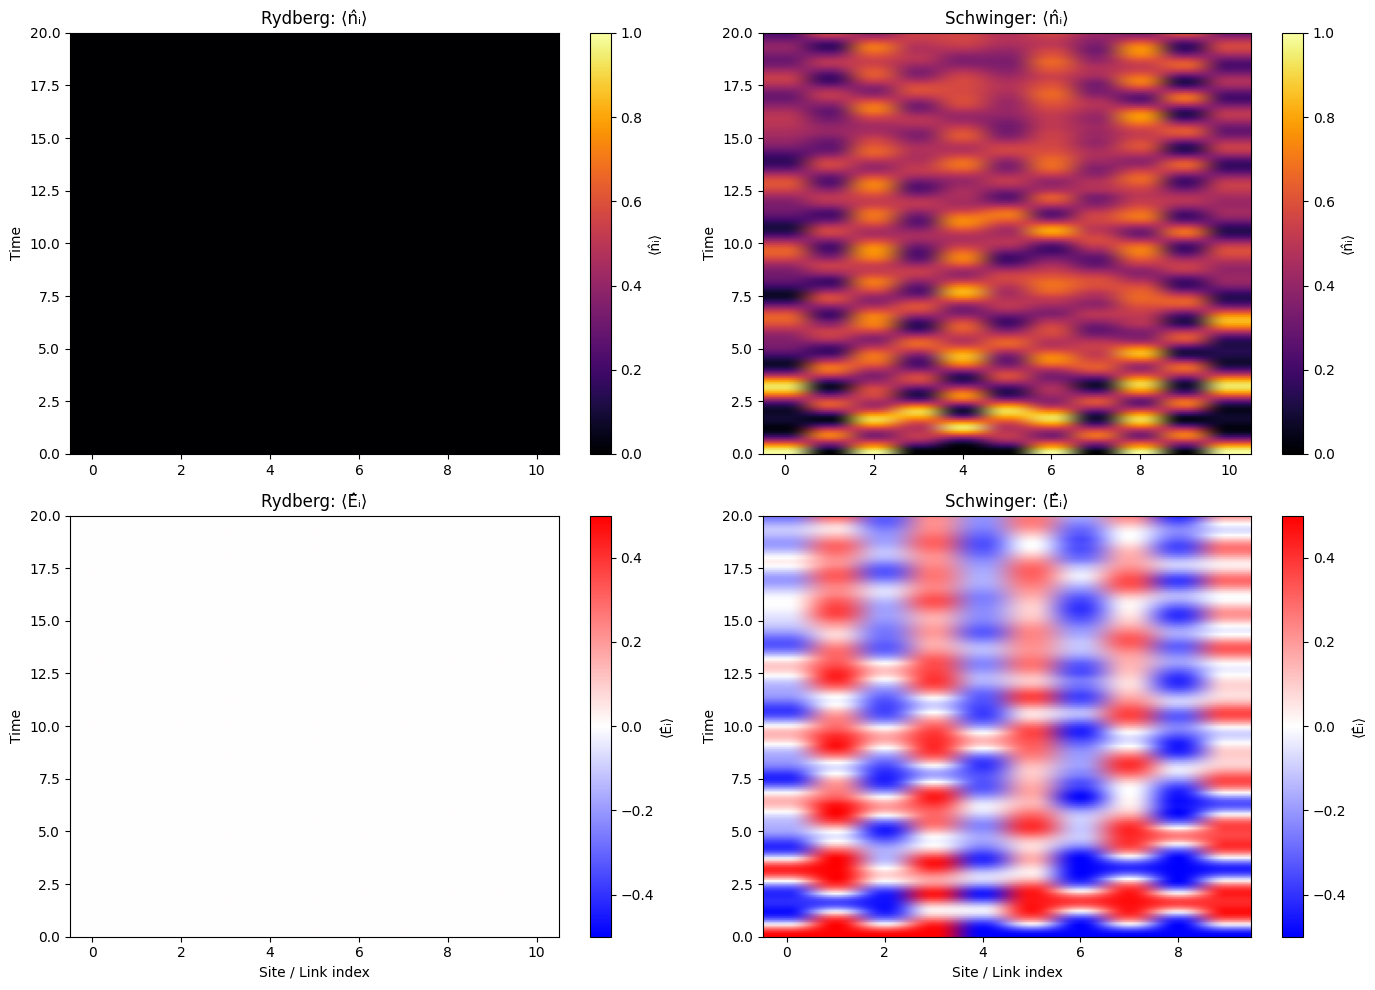

In [29]:
models = ["Rydberg", "Schwinger"]
psi_lists = [psi_t_r_list, psi_t_s_list]
n_ops_lists = [n_ops_r, n_ops_s]
E_ops_lists = [E_ops_r, E_ops_s]

compare_models(models, psi_lists, n_ops_lists, E_ops_lists, t_vals)

### Other Plots

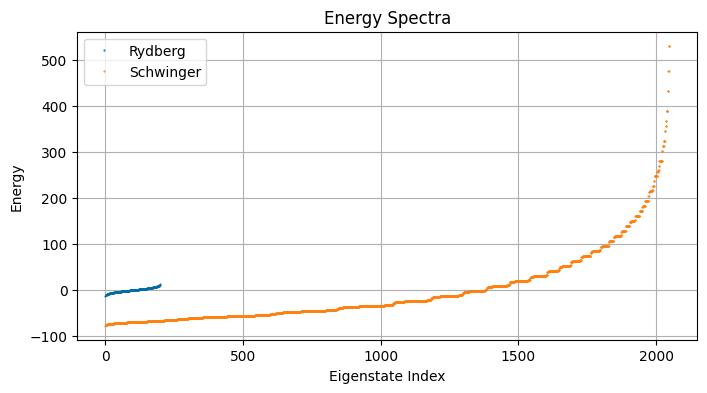

In [30]:
# Energy spectra
plt.figure(figsize=(8,4))
plt.plot(np.sort(e_vals_r), '.', markersize=1, label="Rydberg")
plt.plot(np.sort(e_vals_s), '.', markersize=1, label="Schwinger")
plt.title("Energy Spectra")
plt.xlabel("Eigenstate Index")
plt.ylabel("Energy")
plt.legend()
plt.grid(True)
plt.show()


/tmp/ipykernel_6696/3901068001.py:9: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


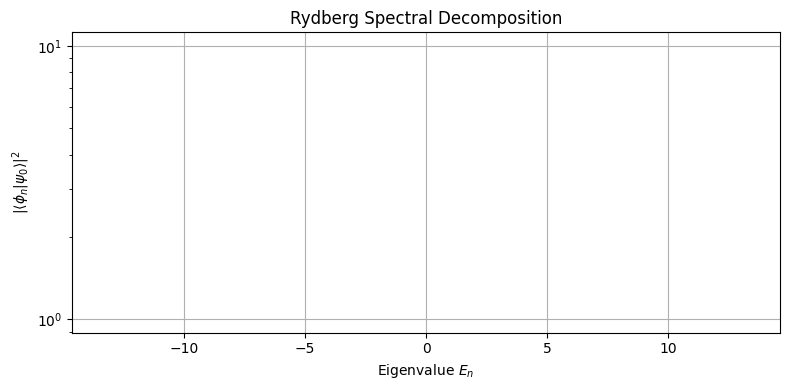

In [31]:

# Spectral decomposition for Rydberg
prob_r = np.abs(C_r)**2
plt.figure(figsize=(8,4))
plt.plot(e_vals_r, prob_r, 'o', markersize=3)
plt.xlabel("Eigenvalue $E_n$")
plt.ylabel(r"$|\langle \phi_n | \psi_0 \rangle|^2$")
plt.title("Rydberg Spectral Decomposition")
plt.grid(True)
plt.yscale('log')
plt.tight_layout()
plt.show()


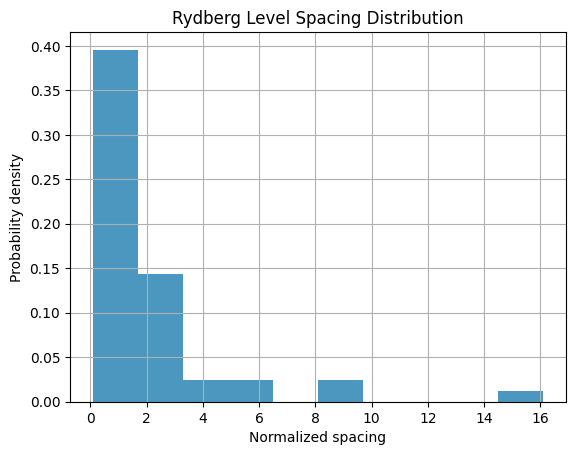

In [32]:

# Level spacing (Rydberg)
E = np.sort(e_vals_r)
s = np.diff(E)
s = s[s>0.01] / np.mean(s)
plt.hist(s, density=True, alpha=0.7)
plt.title("Rydberg Level Spacing Distribution")
plt.xlabel("Normalized spacing")
plt.ylabel("Probability density")
plt.grid(True)
plt.show()